For help implementing the adaboost algorithm, I used these resource to ensure I had the right parameters: https://towardsdatascience.com/adaboost-for-dummies-breaking-down-the-math-and-its-equations-into-simple-terms-87f439757dcf



In [79]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame
import string


#letter = pd.read_csv('letter-recognition.data',header=None)
#this is a multiclass dataset. Going to have to do some weird things to it.
col_names = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar',
            'x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']


letters = pd.read_csv('letter-recognition.data',header=None, names=col_names)
letters = letters[letters.letter != 'A']
letters = letters[letters.letter != 'B']
letters = letters[letters.letter != 'D']
letters = letters[letters.letter != 'E']
letters = letters[letters.letter != 'F']
letters = letters[letters.letter != 'H']
letters = letters[letters.letter != 'I']
letters = letters[letters.letter != 'J']
letters = letters[letters.letter != 'K']
letters = letters[letters.letter != 'L']
letters = letters[letters.letter != 'M']
letters = letters[letters.letter != 'N']
letters = letters[letters.letter != 'O']
letters = letters[letters.letter != 'P']
letters = letters[letters.letter != 'Q']
letters = letters[letters.letter != 'R']
letters = letters[letters.letter != 'S']
letters = letters[letters.letter != 'T']
letters = letters[letters.letter != 'U']
letters = letters[letters.letter != 'V']
letters = letters[letters.letter != 'W']
letters = letters[letters.letter != 'X']
letters = letters[letters.letter != 'Y']
letters = letters[letters.letter != 'Z']

#letters = labelencoder.fit_transform(letters)
lett = {'C': 0,'G': 1} 

letters.letter = [lett[item] for item in letters.letter] 

X1 = letters.drop(letters.columns[0], axis=1)
y1 = letters.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X1, y1)

In [80]:
credit = pd.read_csv('german.data-numeric',sep='\s+',header=None)
#credit.head()
#good or bad credit, last column
X2 = credit.iloc[:,:-1] # Features 
y2 = credit.iloc[:,-1] # Target 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

In [81]:
spam = pd.read_csv('spambase.data',header=None)
#spam.head()
#last column is spam (1) or not spam (0)
X3 = spam.iloc[:,:-1] # Features 
y3 = spam.iloc[:,-1] # Target 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3)

#AdaBoost Algorithm 

When writing the following code, I was also inspired by this resource: https://xavierbourretsicotte.github.io/AdaBoost.html

In [11]:

#The input of your function is the training and test sets, as well as the number of rounds of boosting T.

#The function should then return the predictions of the final combined classifier on the given training and test examples, as well as the training and test #error rate of the combined classifier following each of the T rounds.
from matplotlib import pyplot as plt


def AdaBoost(X,y, M, tree_depth):
    #Initialization of utility variables
    N = len(y)
    mod_list, y_predict_list, mod_error_list, stages, weights = [], [],[],[],[]

    #Initialize the weights
    w = np.ones(N) / N
    #For m = 1 to M
    for m in range(M):   

        #train the base learner with varying depths depending on experiment
        mod = DecisionTreeClassifier(max_depth = tree_depth)
        mod.fit(X, y, sample_weight=w)
        #predictions
        y_predict = mod.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #test error, one for each round of boosting
        #error = sum(w(i) * terror(i)) / sum(w)
        #check the training weight for each instance
        mod_error = np.mean( np.average(incorrect, weights=w, axis=0))
        
        #Stage Value
        #A stage value is calculated for the trained model which provides a weighting for any predictions that the model makes. 
        #stage = ln((1-error) / error)
        #use this to make predictions for test data
        stage =  np.log((1. - mod_error) / mod_error)

        #Boost the actual weights
        w *= np.exp(stage * incorrect * ((w > 0) | (stage < 0)))

        #Save iteration values
        mod_list.append(mod)
        y_predict_list.append(y_predict.copy())
        mod_error_list.append(mod_error.copy())
        stages.append(stage.copy())
        weights.append(w.copy())
        


    #Convert to np array for convenience   
    mod_list = np.asarray(mod_list)
    y_predict_list = np.asarray(y_predict_list)
    mod_error_list = np.asarray(mod_error_list)
    stages = np.asarray(stages)
    weights = np.asarray(weights)

    preds = (np.array([np.sign((y_predict_list[:,point] * stages).sum()) for point in range(N)]))
    #print('Accuracy of train = ', (preds == y).sum() / N) 


    return mod_list, y_predict_list, mod_error_list, stages, weights

In [12]:
def predict(X,y,mods,weights,stages,tree_depth):    
    N = len(y)
    weights, y_predict_list, mod_error_list, = [], [], []

    w = np.ones(N) / N
    for m,s in zip(mods,stages):   
        mod = DecisionTreeClassifier(max_depth = tree_depth)
        mod.fit(X, y, sample_weight=w)
        y_predict = mod.predict(X)
        incorrect = (y_predict != y)
        mod_error = np.mean( np.average(incorrect, weights=w, axis=0))
        #use stage values from trained data
        w *= np.exp(s * incorrect * ((w > 0) | (s < 0)))
        #mod_list.append(mod)
        y_predict_list.append(y_predict.copy())
        mod_error_list.append(mod_error.copy())
        weights.append(w.copy())
        
    y_predict_list = np.asarray(y_predict_list)
    mod_error_list = np.asarray(mod_error_list)
    preds = (np.array([np.sign((y_predict_list[:,point] * stages).sum()) for point in range(N)]))
    accuracy = (preds == y).sum() / N
    #print('Accuracy of test = ', (preds == y).sum() / N) 


    return mod_error_list, accuracy


First experiment: plot test error for tree of max depth 1 (decision stump) over 100 rounds of boosting, for all three datasets. 

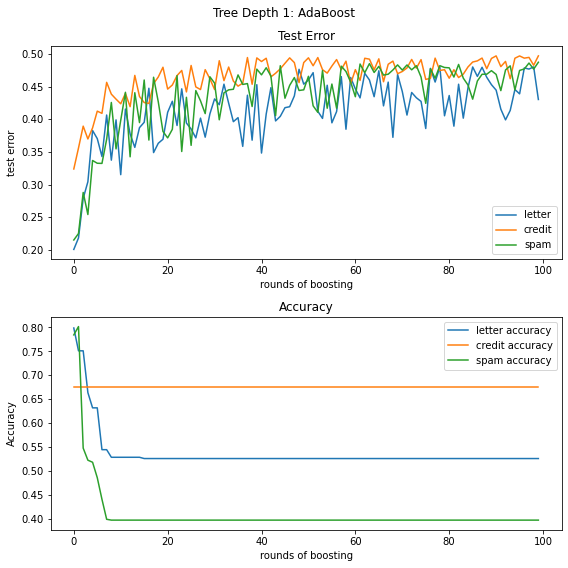

In [33]:
err_letter = []
acc_letter = []
err_credit = []
acc_credit = []
err_spam = []
acc_spam = []

for t in range(100):
    E, Y, EE, S, W = AdaBoost(X_train,y_train,t+1,1)
    test_error, ac = predict(X_test,y_test,E,W,S,1)
    err_letter.append(test_error[t])
    acc_letter.append(ac)

    E2, Y2, EE2, S2, W2 = AdaBoost(X_train2,y_train2,t+1,1)
    test_error2, ac2 = predict(X_test2,y_test2,E2,W2,S2,1)
    err_credit.append(test_error2[t])
    acc_credit.append(ac2)

    E3, Y3, EE3, S3, W3 = AdaBoost(X_train3,y_train3,t+1,1)
    test_error3, ac3 = predict(X_test3,y_test3,E3,W3,S3,1)
    err_spam.append(test_error3[t])
    acc_spam.append(ac3)

err_letter = list(err_letter)
err_credit = list(err_credit)
err_spam = list(err_spam)

acc_letter = list(acc_letter)
acc_credit = list(acc_credit)
acc_spam = list(acc_spam)


fig, ax = plt.subplots(2,figsize=(8,8))
fig.suptitle('Tree Depth 1: AdaBoost')

ax[0].plot(err_letter,label='letter')
ax[0].plot(err_credit,label='credit')
ax[0].plot(err_spam,label='spam')
ax[0].set_xlabel('rounds of boosting')
ax[0].set_ylabel('test error')
ax[0].set_title('Test Error')
ax[0].legend()


ax[1].plot(acc_letter,label='letter accuracy')
ax[1].plot(acc_credit,label='credit accuracy')
ax[1].plot(acc_spam,label='spam accuracy')
ax[1].set_xlabel('rounds of boosting')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()





Second experiment: plot test error of a deeper tree (max depth 8) over 100 rounds of boosting, for all three datasets.

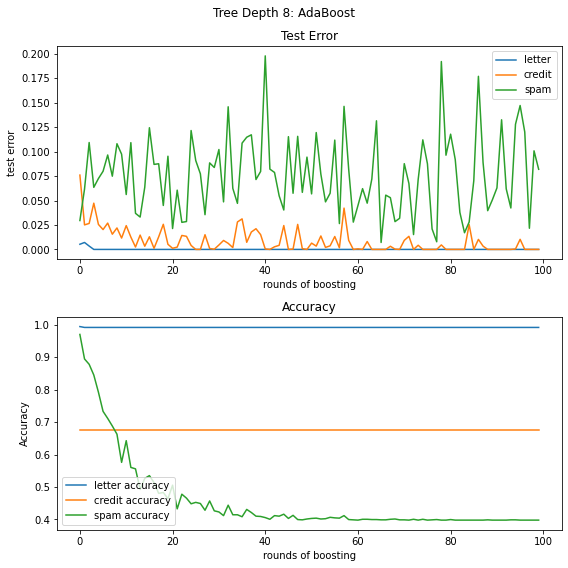

In [34]:
err_letter = []
acc_letter = []
err_credit = []
acc_credit = []
err_spam = []
acc_spam = []

for t in range(100):
    E, Y, EE, S, W = AdaBoost(X_train,y_train,t+1,8)
    test_error, ac = predict(X_test,y_test,E,W,S,8)
    err_letter.append(test_error[t])
    acc_letter.append(ac)

    E2, Y2, EE2, S2, W2 = AdaBoost(X_train2,y_train2,t+1,8)
    test_error2, ac2 = predict(X_test2,y_test2,E2,W2,S2,8)
    err_credit.append(test_error2[t])
    acc_credit.append(ac2)

    E3, Y3, EE3, S3, W3 = AdaBoost(X_train3,y_train3,t+1,8)
    test_error3, ac3 = predict(X_test3,y_test3,E3,W3,S3,8)
    err_spam.append(test_error3[t])
    acc_spam.append(ac3)

err_letter = list(err_letter)
err_credit = list(err_credit)
err_spam = list(err_spam)

acc_letter = list(acc_letter)
acc_credit = list(acc_credit)
acc_spam = list(acc_spam)


fig, ax = plt.subplots(2,figsize=(8,8))
fig.suptitle('Tree Depth 8: AdaBoost')

ax[0].plot(err_letter,label='letter')
ax[0].plot(err_credit,label='credit')
ax[0].plot(err_spam,label='spam')
ax[0].set_xlabel('rounds of boosting')
ax[0].set_ylabel('test error')
ax[0].set_title('Test Error')
ax[0].legend()


ax[1].plot(acc_letter,label='letter accuracy')
ax[1].plot(acc_credit,label='credit accuracy')
ax[1].plot(acc_spam,label='spam accuracy')
ax[1].set_xlabel('rounds of boosting')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



[0.9153439153439153]


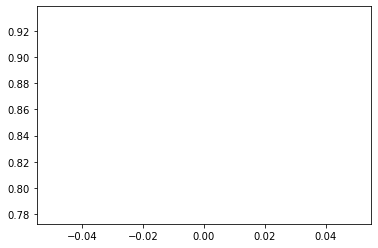

In [95]:
#comparison to sklearn

from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

def SklearnAdaBoost(Xtrain,Ytrain,Xtest,Ytest,depth, M):
    ada = AdaBoostClassifier(base_estimator=(DecisionTreeClassifier(max_depth = depth)),n_estimators=M)
    model = ada.fit(Xtrain, Ytrain)
    y_pred = model.predict(Xtest)
    acc = metrics.accuracy_score(Ytest, y_pred)
    return acc
#plots
acc1 = []
acc2 = []
acc3 = []
for t in range(2):
    acc = SklearnAdaBoost(X_train,y_train,X_test,y_test,1,t+1)
    acc1.append(acc)
    acc = SklearnAdaBoost(X_train2,y_train2,X_test2,y_test2,1,t+1)
    acc2.append(acc)
    acc = SklearnAdaBoost(X_train3,y_train3,X_test3,y_test3,1,t+1)
    acc3.append(acc3)

print(acc1)

plt.plot(acc1)
plt.plot(acc2)
plt.plot(acc3)
plt.show()






#Bagging Algorithm

In [53]:
#number of 'rounds' corresponds to the number of trees in the forest

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score



I used consulted this resource when implementing the bagging algorithm:
https://www.quantstart.com/articles/bootstrap-aggregation-random-forests-and-boosted-trees/

First, experiment: tree depth of 1, like before.

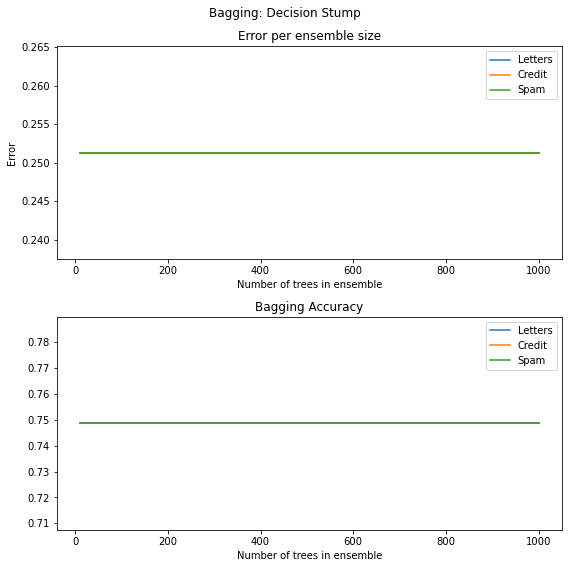

In [90]:
def Bagging(Xtrain,Ytrain,Xtest,Ytest,num_trees,tree_depth):
    step = 10
    axis_step = int(num_trees/step)
    estimators = np.zeros(axis_step)
    bagging_mse = np.zeros(axis_step)
    rf_mse = np.zeros(axis_step)
    boosting_mse = np.zeros(axis_step)
    acc = []
    for i in range(0, axis_step):
        bagging = BaggingClassifier(
                DecisionTreeClassifier(max_depth=tree_depth), 
                n_estimators=step_factor*(i+1)
            )
        bagging.fit(X_train, y_train)
        y_preds = bagging.predict(X_test)
        acc.append(accuracy_score(y_test,y_preds))
        mse = mean_squared_error(y_test, bagging.predict(X_test))
        estimators[i] = step_factor*(i+1)
        bagging_mse[i] = mse
    return estimators, bagging_mse, acc

fig, ax = plt.subplots(2,figsize=(8,8))
fig.suptitle('Bagging: Decision Stump')
E,B,A = Bagging(X_train,y_train,X_test,y_test,1000,1)
ax[0].plot(E, B, label='Letters')
ax[1].plot(E, A, label='Letters')
E,B,A = Bagging(X_train2,y_train2,X_test2,y_test2,1000,1)
ax[0].plot(E, B, label='Credit')
ax[1].plot(E, A, label='Credit')
E,B,A = Bagging(X_train3,y_train3,X_test3,y_test3,1000,1)
ax[0].plot(E, B, label='Spam')
ax[1].plot(E, A, label='Spam')
ax[0].set_title('Error per ensemble size')
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of trees in ensemble')
ax[0].legend()
ax[1].set_xlabel('Number of trees in ensemble')
ax[1].set_title('Bagging Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()
plt.close()






Second experiment: tree depth 8

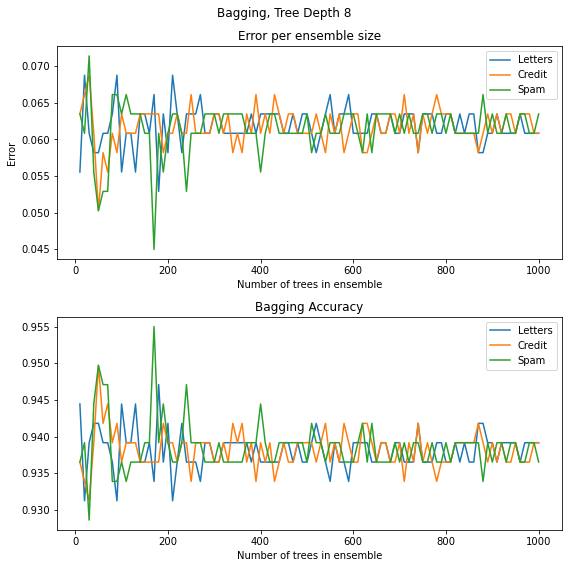

In [91]:
fig, ax = plt.subplots(2,figsize=(8,8))
fig.suptitle('Bagging, Tree Depth 8')
E,B,A = Bagging(X_train,y_train,X_test,y_test,1000,8)
ax[0].plot(E, B, label='Letters')
ax[1].plot(E, A, label='Letters')
E,B,A = Bagging(X_train2,y_train2,X_test2,y_test2,1000,8)
ax[0].plot(E, B, label='Credit')
ax[1].plot(E, A, label='Credit')
E,B,A = Bagging(X_train3,y_train3,X_test3,y_test3,1000,8)
ax[0].plot(E, B, label='Spam')
ax[1].plot(E, A, label='Spam')
ax[0].set_title('Error per ensemble size')
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Number of trees in ensemble')
ax[0].legend()
ax[1].set_xlabel('Number of trees in ensemble')
ax[1].set_title('Bagging Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()
plt.close()

#Algorithm Comparison

While both algorithms succeeded in achieving a high accuracy for prediction in all three datasets, it seems like the bagging algorithm performs better long-term. The issue that most clearly presents itself in the comparison of these two algorithms is that of overfitting. In the case of AdaBoost, particularly with the Spam dataset, the more rounds of boosting that occur, the higher amounts of error occur, and the accuracy decreases. Interestingly, this issue is behaviorally quite different between different depths of trees. In AdaBoost, when only using the decision stump, the algorithm performs the best when there are only a few rounds of boosting. For a deeper tree, the experiment shows that this is not the case with two of the datasets: letter and credit. It appears that for these two datasets, continuing more rounds of AdaBoost has no effect whatsoever, as evidenced by the lack of change of slope over time. In both algorithms, the Spam datatset has the most extreme behavior- it is the most suseptible to both higher amounts of error and higher accuracy. So, it seems that the amount of overfitting possible from these two algorithms is greatly influenced by the type of data they are fitting. But, for the letter dataset, Boosting seems to do an extremely good job. So good in fact, that there is no problem of overfitting whatsoever and hardly any increase in error as the number of boosting rounds are increased (for the deeper tree experiment, that is). For the decision stump, or shallow tree experiment, the letter dataset is indeed still suseptible to overfittinng like the other datasets. So, for the letter dataset, I would say that AdaBoost is the superior algorithm, while for the other two datasets, Boosting seems to be more accurate. 